# Genomic Selection Post-Training Analysis & Visualization
This notebook analyzes calibrated predicted breeding values produced by the training pipeline.

## Data Loading

In [23]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

## update file path
ml_path = "gebvs/nocal/Oct22_MAF02_GEBVs_10foldCV.csv"
r_path = "/work/tfs3/gsAI/4paul/gebvs/Oct22_0.01MAF_GEBV.csv"

df1 = pd.read_csv(ml_path)
df2 = pd.read_csv(r_path)
merged = pd.merge(df1, df2, on=['ID', 'Status'])

remove = 'SD'
drop = merged.filter(regex=remove).columns
merged = merged.drop(columns=drop)
df = merged
df

ID  Status        LR        RF        GB  GBLUP_Mean  LASSO_Mean  \
0        B-1     1.0  0.424877  0.518536  0.520939       0.465      0.4630   
1     B-1000     0.0  0.326451  0.444602  0.190032       0.661      0.6704   
2     B-1002     0.0  0.474595  0.519257  0.380533       0.479      0.4751   
3     B-1003     0.0  0.507081  0.527041  0.541509       0.511      0.5121   
4     B-1005     0.0  0.528990  0.524107  0.529234       0.546      0.5454   
...      ...     ...       ...       ...       ...         ...         ...   
2359   Y_988     1.0  0.554521  0.560937  0.601638       0.549      0.5449   
2360   Y_991     1.0  0.736750  0.574319  0.643335       0.634      0.6301   
2361   Y_992     0.0  0.591608  0.551127  0.618673       0.647      0.6591   
2362   Y_995     1.0  0.780471  0.587592  0.707360       0.725      0.7418   
2363   Y_998     1.0  0.784414  0.574560  0.670992       0.812      0.8328   

      RKHS_Mean  EGBLUP_Mean  BRR_Mean  BayesB_Mean  
0        0.4525     0.462394    0.4636       0.4885  
1        0.4752     0.609911    0.6721       0.1456  
2        0.4830     0.475803    0.4798       0.4372  
3        0.5208     0.509350    0.5133       0.5126  
4        0.5357     0.531571    0.5461       0.5564  
...         ...          ...       ...          ...  
2359     0.5498     0.552196    0.5468       0.5349  
2360     0.6319     0.604325    0.6303       0.6307  
2361     0.6656     0.677591    0.6606       0.6673  
2362     0.7478     0.753736    0.7365       0.7578  
2363     0.7918     0.780175    0.8257       0.8137  

[2364 rows x 11 columns]

## 0. Compute raw correlation for ML models only

In [25]:
ml_path = "gebvs/nocal/Oct22_MAF02_GEBVs_10foldCV.csv"
df1 = pd.read_csv(ml_path)
ml_models = ['LR', 'RF', 'GB']
y_true = df1["Status"].values

for model in ml_models:
    corr, pval = pearsonr(df1[model].values, y_true)
    print(f"{model}: Pearson correlation = {corr:.8f} (p={pval:.3e})")


LR: Pearson correlation = 0.25328612 (p=6.331e-36)
RF: Pearson correlation = 0.24354368 (p=2.912e-33)
GB: Pearson correlation = 0.29505611 (p=1.064e-48)


## 1. Descriptive Statistics & Rank Comparison

In [26]:
models = ['LR', 'RF', 'GB', 'GBLUP_Mean', 'LASSO_Mean', 'RKHS_Mean', 'EGBLUP_Mean', 'BRR_Mean', 'BayesB_Mean']
# Descriptive statistics for predicted breeding values
stats = df[models].describe().T
display(stats)

# Top 100 individuals for each model and rank comparison
rankings = {}
for model in models:
    top100 = df.nlargest(100, model)[['ID', model]].copy()
    top100['Rank_in_'+model] = np.arange(1, 101)
    for other in models:
        if other != model:
            top100['Rank_in_'+other] = df[other].rank(method='min', ascending=False).loc[top100.index].astype(int)
    rankings[model] = top100

rankings['GB']

count      mean       std       min       25%       50%  \
LR           2364.0  0.524598  0.122342  0.142351  0.450971  0.513540   
RF           2364.0  0.531765  0.028653  0.397153  0.516302  0.527898   
GB           2364.0  0.536052  0.099226  0.167473  0.490398  0.539409   
GBLUP_Mean   2364.0  0.530473  0.115427  0.112000  0.459000  0.520500   
LASSO_Mean   2364.0  0.530580  0.125579  0.082200  0.455800  0.521100   
RKHS_Mean    2364.0  0.530783  0.120574  0.098600  0.461875  0.521050   
EGBLUP_Mean  2364.0  0.530442  0.120624  0.128487  0.459550  0.516979   
BRR_Mean     2364.0  0.530593  0.122163  0.093800  0.456625  0.520550   
BayesB_Mean  2364.0  0.530032  0.133879 -0.136200  0.472200  0.536400   

                  75%       max  
LR           0.601506  0.895144  
RF           0.548919  0.627873  
GB           0.594066  0.798586  
GBLUP_Mean   0.598000  0.946000  
LASSO_Mean   0.607600  0.970100  
RKHS_Mean    0.603925  0.948800  
EGBLUP_Mean  0.601646  0.952306  
BRR_Mean     0.605225  0.957400  
BayesB_Mean  0.605750  0.919500

ID        GB  Rank_in_GB  Rank_in_LR  Rank_in_RF  \
2005  Y_1263  0.798586           1           3           1   
2189   Y_648  0.796623           2           1           2   
1736    P628  0.792263           3           5           9   
2319   Y_886  0.776784           4          12           6   
1857    P909  0.771657           5          10           7   
...      ...       ...         ...         ...         ...   
627   GS1299  0.700987          96          60         148   
2326   Y_908  0.700918          97         163          23   
2221   Y_718  0.700492          98         139          71   
798    GS695  0.700344          99          82         207   
1785    P738  0.700294         100         229         181   

      Rank_in_GBLUP_Mean  Rank_in_LASSO_Mean  Rank_in_RKHS_Mean  \
2005                   1                   2                  1   
2189                  14                  12                 10   
1736                   8                   8                  5   
2319                   5                   6                  3   
1857                  19                  23                  8   
...                  ...                 ...                ...   
627                   11                  11                 19   
2326                 167                 202                192   
2221                  22                  27                 16   
798                   20                  19                 15   
1785                 365                 375                287   

      Rank_in_EGBLUP_Mean  Rank_in_BRR_Mean  Rank_in_BayesB_Mean  
2005                    2                 2                    2  
2189                    9                13                   29  
1736                    4                 7                   10  
2319                    5                 6                    4  
1857                   15                22                   14  
...                   ...               ...                  ...  
627                    14                11                   11  
2326                  184               193                  239  
2221                   21                24                   30  
798                    11                19                   39  
1785                  363               371                  511  

[100 rows x 11 columns]

## 2. Breeding Value Histograms

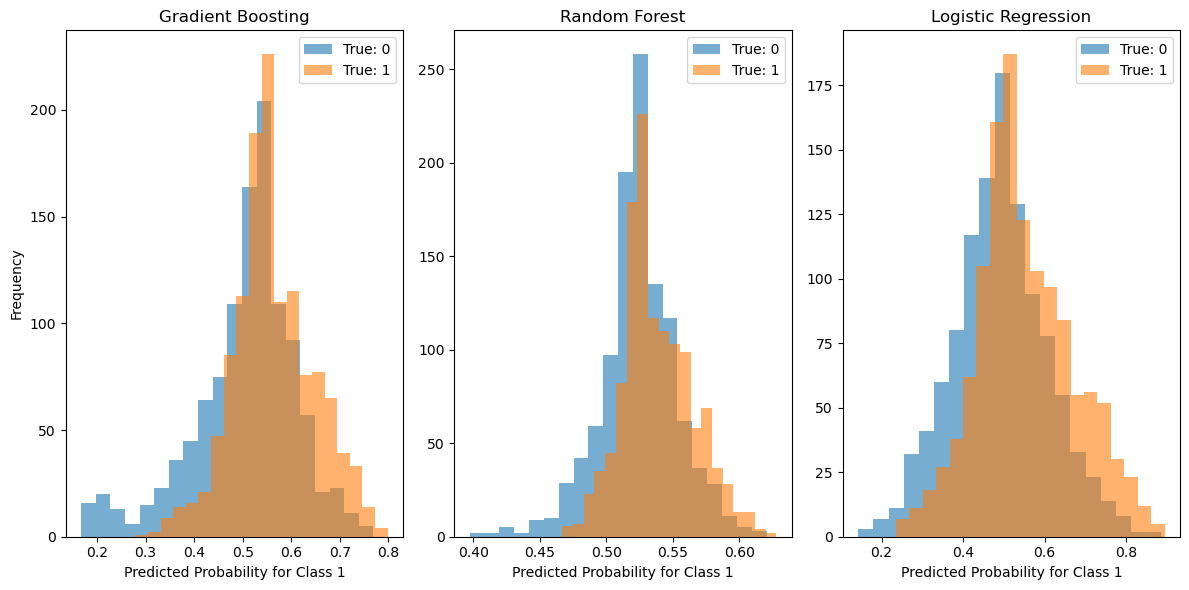

In [27]:
import matplotlib.pyplot as plt

# Extract probabilities and true labels from df
gb_class1_probs = df["GB"].values
rf_class1_probs = df["RF"].values
lr_class1_probs = df["LR"].values
y_true = df["Status"].values  # true phenotype (0/1)

plt.figure(figsize=(12, 6))

# Gradient Boosting
plt.subplot(1, 3, 1)
plt.hist(gb_class1_probs[y_true == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(gb_class1_probs[y_true == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Gradient Boosting')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
plt.hist(rf_class1_probs[y_true == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(rf_class1_probs[y_true == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Random Forest')
plt.xlabel('Predicted Probability for Class 1')
plt.legend()

# Logistic Regression
plt.subplot(1, 3, 3)
plt.hist(lr_class1_probs[y_true == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(lr_class1_probs[y_true == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Logistic Regression')
plt.xlabel('Predicted Probability for Class 1')
plt.legend()

plt.tight_layout()
plt.show()


## 3. Correlation & Performance Plot

LR: Pearson correlation = 0.25328612 (p=6.331e-36)
RF: Pearson correlation = 0.24354368 (p=2.912e-33)
GB: Pearson correlation = 0.29505611 (p=1.064e-48)
GBLUP_Mean: Pearson correlation = 0.22337190 (p=4.084e-28)
LASSO_Mean: Pearson correlation = 0.22824415 (p=2.586e-29)
RKHS_Mean: Pearson correlation = 0.24003730 (p=2.478e-32)
EGBLUP_Mean: Pearson correlation = 0.22653552 (p=6.856e-29)
BRR_Mean: Pearson correlation = 0.22729940 (p=4.438e-29)
BayesB_Mean: Pearson correlation = 0.26382324 (p=6.151e-39)


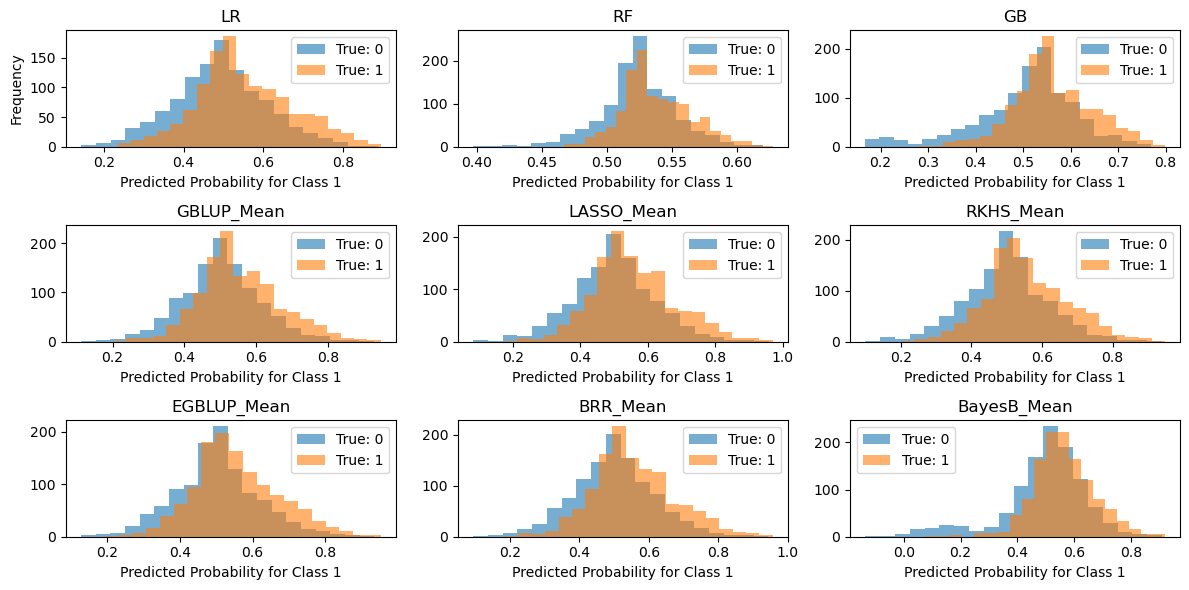

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

y_true = df["Status"].values

for model in models:
    corr, pval = pearsonr(df[model].values, y_true)
    print(f"{model}: Pearson correlation = {corr:.8f} (p={pval:.3e})")

plt.figure(figsize=(12, 6))

n_models = len(models)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

for i, model in enumerate(models, 1):
    probs = df[model].values
    plt.subplot(n_rows, n_cols, i)
    plt.hist(probs[y_true == 0], bins=20, alpha=0.6, label="True: 0")
    plt.hist(probs[y_true == 1], bins=20, alpha=0.6, label="True: 1")
    plt.title(f"{model}")
    plt.xlabel("Predicted Probability for Class 1")
    plt.ylabel("Frequency" if i == 1 else "")
    plt.legend()

plt.tight_layout()
plt.show()


## 4. Model Correlation Plot

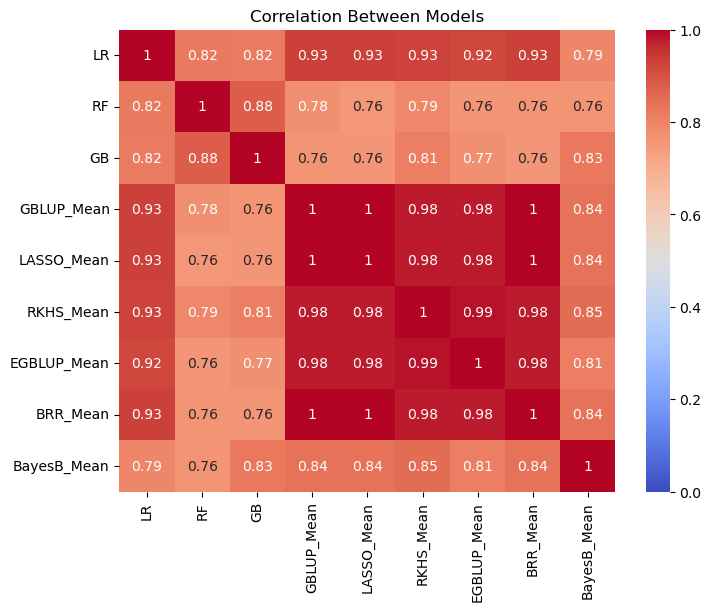

In [29]:
# Average breeding value per individual across folds
avg_preds = df.groupby('ID')[models].mean()
corr_matrix = avg_preds.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlation Between Models')
plt.show()

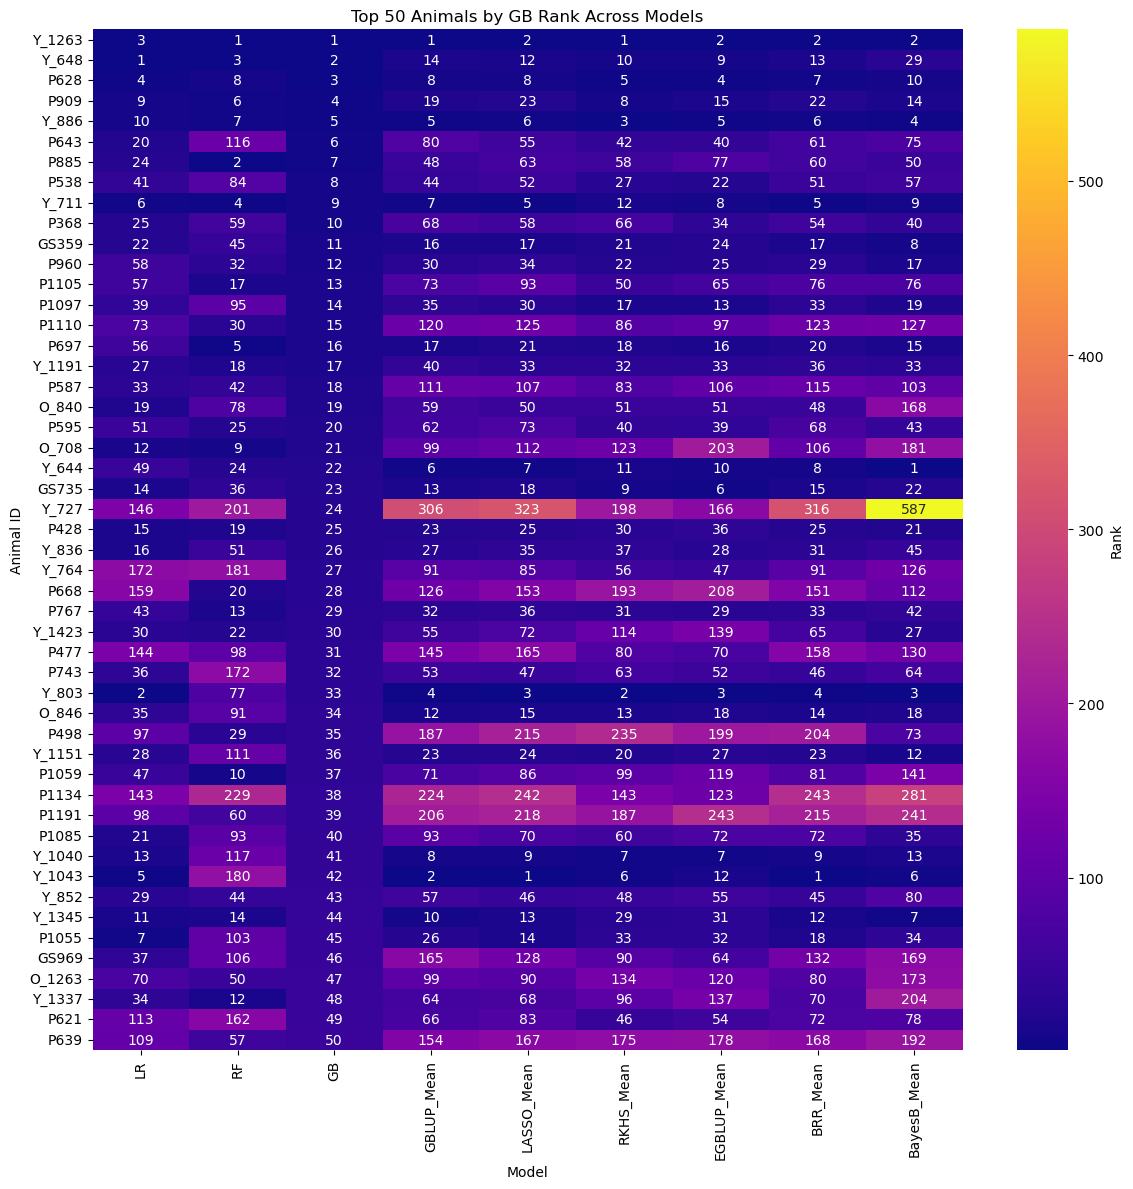

In [20]:
rank_only = df.set_index("ID").rank(ascending=False).astype(int)
rank_only = rank_only.drop('Status', axis=1)
rank_only = rank_only.reset_index()

top_n = 50
subset = rank_only.sort_values("GB").head(top_n).set_index("ID")  # or use average rank
plt.figure(figsize=(12, 12))
sns.heatmap(subset, annot=True, cmap="plasma", fmt="d", cbar_kws={'label': 'Rank'})
plt.title(f"Top {top_n} Animals by GB Rank Across Models")
plt.ylabel("Animal ID")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


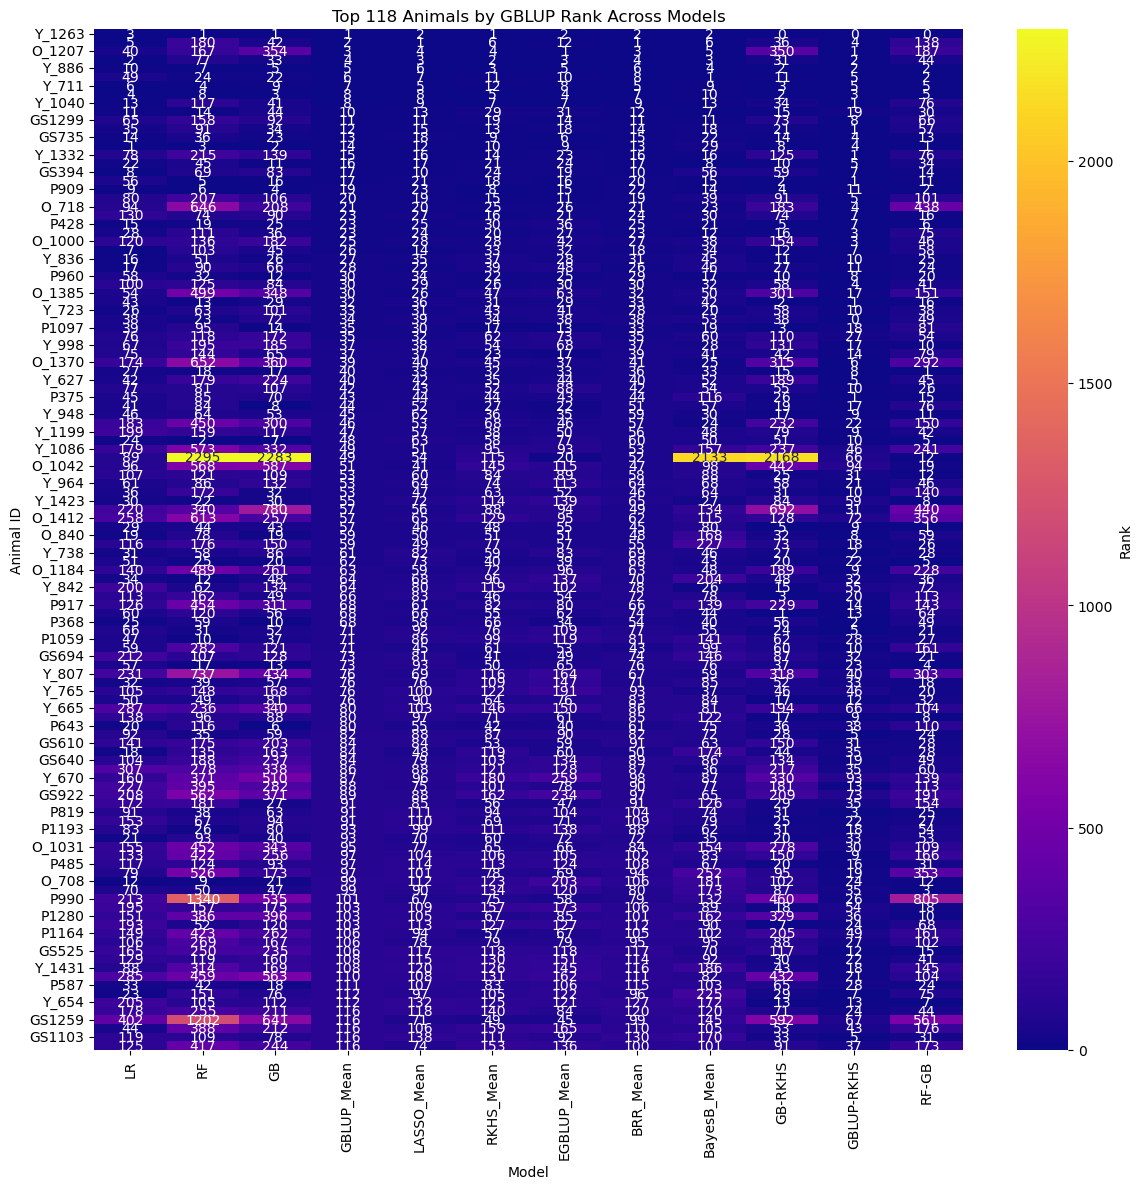

In [30]:
subset2 = rank_only.sort_values("GBLUP_Mean").head(top_n).set_index("ID")  # or use average rank
plt.figure(figsize=(12, 12))
sns.heatmap(subset2, annot=True, cmap="plasma", fmt="d", cbar_kws={'label': 'Rank'})
plt.title(f"Top {top_n} Animals by GBLUP Rank Across Models")
plt.ylabel("Animal ID")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


In [31]:
rank_only['GB-RKHS'] = np.abs(rank_only['RKHS_Mean'] - rank_only['GB'])
rank_only
print(np.mean(rank_only['GB-RKHS']))

rank_only['GBLUP-RKHS'] = np.abs(rank_only['RKHS_Mean'] - rank_only['GBLUP_Mean'])
rank_only
print(np.mean(rank_only['GBLUP-RKHS']))

rank_only['RF-GB'] = np.abs(rank_only['RF'] - rank_only['GB'])
rank_only
print(np.mean(rank_only['RF-GB']))


297.34179357022
107.61040609137056
222.422165820643


In [32]:
temp = df.copy() 
label_col = 'Status' 
model_columns = [col for col in temp.columns if col not in ['ID', label_col]]

# Initialize result containers
full_stats = []
top10_stats = []

for model in model_columns:
    # Create binary predictions using GEBV threshold
    temp[f"{model}_pred"] = (temp[model] > 0.5).astype(int)
    total_pos_rate = temp[label_col].mean() * 100
    model_pos_rate = temp[f"{model}_pred"].mean() * 100

    full_stats.append({
        'Model': model,
        '% Predicted Positives': model_pos_rate,
        '% Actual Positives': total_pos_rate
    })

    # ---------- TOP 10% ----------
    top_n = int(len(df) * 0.05)
    df_sorted = temp.sort_values(by=model, ascending=False).head(top_n)

    top_model_pos_rate = df_sorted[f"{model}_pred"].mean() * 100
    top_actual_pos_rate = df_sorted[label_col].mean() * 100

    top10_stats.append({
        'Model': model,
        '% Predicted Positives (Top 5%)': top_model_pos_rate,
        '% Actual Positives (Top 5%)': top_actual_pos_rate
    })

# Convert to DataFrames
full_stats_df = pd.DataFrame(full_stats).set_index('Model')
top10_stats_df = pd.DataFrame(top10_stats).set_index('Model')
print(full_stats_df)
print(top10_stats_df)

             % Predicted Positives  % Actual Positives
Model                                                 
LR                       56.175973           53.130288
RF                       89.424704           53.130288
GB                       71.573604           53.130288
GBLUP_Mean               59.771574           53.130288
LASSO_Mean               59.179357           53.130288
RKHS_Mean                59.813875           53.130288
EGBLUP_Mean              58.460237           53.130288
BRR_Mean                 59.644670           53.130288
BayesB_Mean              65.566836           53.130288
             % Predicted Positives (Top 5%)  % Actual Positives (Top 5%)
Model                                                                   
LR                                    100.0                    80.508475
RF                                    100.0                    72.881356
GB                                    100.0                    76.271186
GBLUP_Mean                    